<a href="https://colab.research.google.com/github/yellowlarva-sketch/aml-fraud-detection/blob/main/02a_autobinning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Transactions for Anti Money Laundering

We aim to develop a predictive model that identifies potential money laundering cases by analyzing patterns in historical account transaction data.

Import Data from Kaggle Project
https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/code

In [ ]:
!pip install optbinning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.9/213.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 5.26.1 which is incompatible.


In [ ]:
# Connect drive to save data
from google.colab import drive
drive.mount('/content/drive')

# Set directory
main_dir = '/content/drive/My Drive/Colab Notebooks/'
input_dir = main_dir + '/00_inputs/'
script_dir = main_dir + '/01_scripts/'
output_dir = main_dir + '/02_outputs/'
model_ver = 'modelv1'
model_dir = output_dir + '{0}/'.format(model_ver)
non_predictive_cols = ['Is Laundering', 'biz_dt', 'Account','X_fold']

# Import libraries
# %pip install 'cvxpy<1.5' ecos scs
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from optbinning import BinningProcess
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
from optbinning import OptimalBinning
import warnings
warnings.filterwarnings("ignore")
import os
os.chdir(script_dir)

from utils import roc_curve_graph

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Here we are predicting whether the account was involved in the laundering activity. Import data and check target label.


In [ ]:
df = pd.read_csv(output_dir + 'modeling_data.csv')
print("Data shape:",df.shape)

predictive_cols = pd.read_csv(output_dir + 'predictive_columns.csv')
id_col = 'Account'
target = 'Is Laundering'
features = list(predictive_cols['0'])
print("Number of features:",len(features))

df[target].value_counts(normalize=False)

Data shape: (1550716, 45)
Number of features: 41


,count
Is Laundering,
0,1546751
1,3965


Split the train and test and out of time validation set.

In [ ]:
# This will be used for cross-validation hyperparameter tuning
X_train = df[df['X_fold'].isin(['train', 'valid'])][features].head(10000)
y_train = df[df['X_fold'].isin(['train', 'valid'])][target].head(10000)

# This will be used for model algorithm comparison & setting optimal threshold
X_test = df[df['X_fold'] == 'test'][features]
y_test = df[df['X_fold'] == 'test'][target]

# This will be used for model algorithm comparison & setting optimal threshold
X_oot = df[df['X_fold'] == 'outoftime'][features]
y_oot = df[df['X_fold'] == 'outoftime'][target]

Define model parameter search space

In [ ]:
search_space = {
    'max_n_bins': hp.choice('max_n_bins', [5, 10, 20]),
    'monotonic_trend': hp.choice('monotonic_trend', ['auto', 'ascending', 'descending']),
    'num_features': hp.choice('num_features', [10, 20, 30]),
    'model_type': hp.choice('model_type', ['lr', 'rf']),

        # Logistic regression params
    'C': hp.loguniform('C', np.log(0.01), np.log(10)),
    'n_estimators': hp.choice('n_estimators', [100, 200]),
    'max_depth': hp.choice('max_depth', [5, 10, None]),

}

model_config = {
  'lr':{
    # Logistic regression params
    'C': hp.loguniform('C', np.log(0.01), np.log(10)),
  },
  'rf':{
    # Random forest params
    'n_estimators': hp.choice('n_estimators', [100, 200]),
    'max_depth': hp.choice('max_depth', [5, 10, None]),
  }
}

In [ ]:
def binning_model_selection(params): #, X_train, y_train, features
    max_n_bins = params['max_n_bins']
    monotonic_trend = params['monotonic_trend']
    num_features = params['num_features']
    model_type = params['model_type']

    # Step 1: Binning
    bp = BinningProcess(
    variable_names=features,
    selection_criteria={"iv": {"min": 0.01}}, #"woe_monotonicity": {"min": 90}, "min_event_rate_diff":
    max_n_bins =max_n_bins,
    binning_fit_params={
        var: {"monotonic_trend": monotonic_trend}
        for var in features
    }
    )

    bp.fit(X_train, y_train)
    X_binned = bp.transform(X_train) #, metric="woe"

    # Step 2: Feature selection
    selector = SelectKBest(score_func=mutual_info_classif, k=num_features)
    X_selected = selector.fit_transform(X_binned, y_train)

    # Step 3: Model selection
    if model_type == 'lr':
        model = LogisticRegression(C=params['C'], solver='liblinear')
    elif model_type == 'rf':
        model = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            random_state=42
        )

    # Step 4: Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_selected, y_train, cv=cv, scoring='roc_auc')
    loss = -scores.mean()

    return {'loss': loss, 'params':params, 'status': STATUS_OK}


Run hyperparameter tuning

In [ ]:
hyperopt_file="binning_model_trials.pkl"

trials = Trials()
best = fmin(
    fn=binning_model_selection,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials
)

# Save trials if needed
with open(hyperopt_file, "wb") as f:
    pickle.dump(trials, f)

100%|██████████| 30/30 [01:12<00:00,  2.40s/trial, best loss: -0.9152924658841493]


Show the optimal model parameter having highest AUROC

In [ ]:
trials = pickle.load(open(hyperopt_file, 'rb'))
sorted_results = sorted(trials.results, key=lambda x: x['loss'])

results = {}

for dic in sorted_results:
    loss = dic['loss']
    results[loss] = dic['params']

bestLoss = list(results.keys())[0]
bestParams = results[bestLoss]

print('Best loss: {:.4f}'.format(bestLoss))
print('Best parameters: {}'.format(bestParams))

Best loss: -0.9153
Best parameters: {'C': 0.022765904176482728, 'max_depth': None, 'max_n_bins': 20, 'model_type': 'lr', 'monotonic_trend': 'auto', 'n_estimators': 200, 'num_features': 30}


In [ ]:
def final_model_fitting(params):
    max_n_bins = params['max_n_bins']
    monotonic_trend = params['monotonic_trend']
    num_features = params['num_features']
    model_type = params['model_type']

    # Step 1: Binning
    bp = BinningProcess(
    variable_names=features,
    selection_criteria={"iv": {"min": 0.02}},
    max_n_bins =max_n_bins,
    binning_fit_params={
        var: {"monotonic_trend": monotonic_trend}
        for var in features
    }
    )

    bp.fit(X_train, y_train)
    X_train_binned = bp.transform(X_train) #, metric="woe"
    with open(model_dir+'/{}_binning.pkl'.format(params['model_type']), 'wb') as f:
            pickle.dump(bp, f)

    # Step 2: Feature selection
    selector = SelectKBest(score_func=mutual_info_classif, k=num_features)
    X_train_selected = selector.fit_transform(X_train_binned, y_train)

    selected_mask = selector.get_support()  # Boolean mask of selected features
    selected_features = np.array(X_train_binned.columns)[selected_mask]
    pd.Series(selected_features.tolist()).to_csv(
            model_dir+'/{}_features.csv'.format(params['model_type']),
            index=False
        )

    # Step 3: Model selection
    if model_type == 'lr':
        model = LogisticRegression(C=params['C'], solver='liblinear')
    elif model_type == 'rf':
        model = RandomForestClassifier(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            random_state=42
        )

    # Step 4: Cross-validation
    model.fit(X_train_selected, y_train)
    with open(model_dir+'/{}_model.pkl'.format(params['model_type']), 'wb') as f:
            pickle.dump(model, f)

    return bp, model, selected_features

Final model fitting based on the selected optimal parameter

In [ ]:
bp, model, selected_features = final_model_fitting(bestParams)

In [ ]:
# Run for whole population
df_binned = bp.transform(df[features])
df['score'] = model.predict_proba(df_binned[selected_features])[:, 1]

Test model performance for all the samples

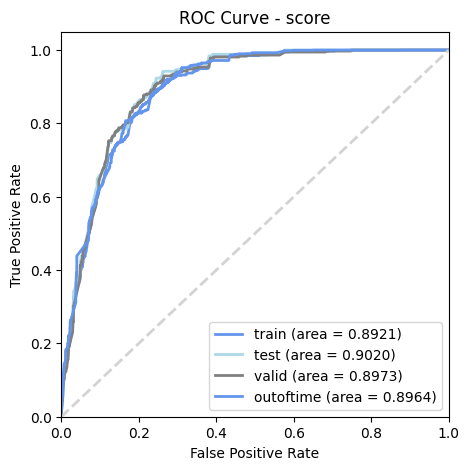

In [ ]:
roc_curve_graph(df, target=target, feature='score', by='X_fold')

Features Information Value

In [ ]:
summary = bp.summary()
summary['selected_postmodel'] = [int(i in selected_features) for i in summary['name']]
summary

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score,selected_postmodel
0,Amount Received,numerical,OPTIMAL,True,4,0.171094,0.02021,0.14419,0.057147,1
1,Amount Paid,numerical,OPTIMAL,True,5,0.388259,0.045446,0.274067,0.112482,1
2,Payment Format_ACH,numerical,OPTIMAL,True,3,2.08784,0.229383,0.665008,0.000004,1
3,Payment Format_Bitcoin,numerical,OPTIMAL,False,1,0.0,0.0,0,0.0,0
4,Payment Format_Cash,numerical,OPTIMAL,False,2,0.003478,0.000435,0.024226,0.00139,0
5,Payment Format_Cheque,numerical,OPTIMAL,True,3,0.322435,0.039022,0.253599,0.716749,1
6,Payment Format_Credit Card,numerical,OPTIMAL,True,4,0.780674,0.086867,0.351692,0.161599,1
7,Payment Format_Reinvestment,numerical,OPTIMAL,False,1,0.0,0.0,0,0.0,0
8,Payment Format_Wire,numerical,OPTIMAL,False,1,0.0,0.0,0,0.0,0
9,Payment Currency_Australian Dollar,numerical,OPTIMAL,False,1,0.0,0.0,0,0.0,0


In [ ]:
len(selected_features)

11

Amount Received


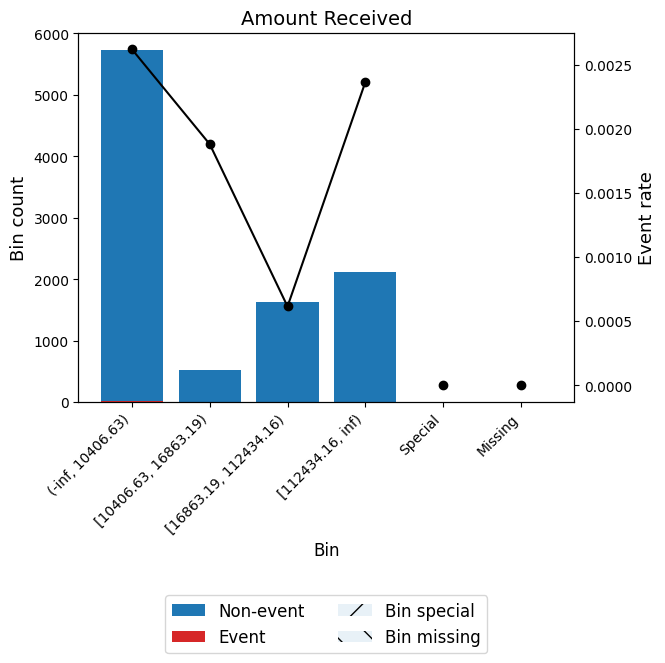

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 10406.63)",5727,0.5727,5712,15,0.002619,-0.174821,0.019118,0.002387
1,"[10406.63, 16863.19)",532,0.0532,531,1,0.001880,0.157667,0.001224,0.000153
2,"[16863.19, 112434.16)",1625,0.1625,1624,1,0.000615,1.275552,0.149627,0.017530
3,"[112434.16, inf)",2116,0.2116,2111,5,0.002363,-0.071616,0.001125,0.000141
4,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.171094,0.020210


In [ ]:
i = 0
print(selected_features[i])
# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True)
binned_var.binning_table.build()

Amount Paid


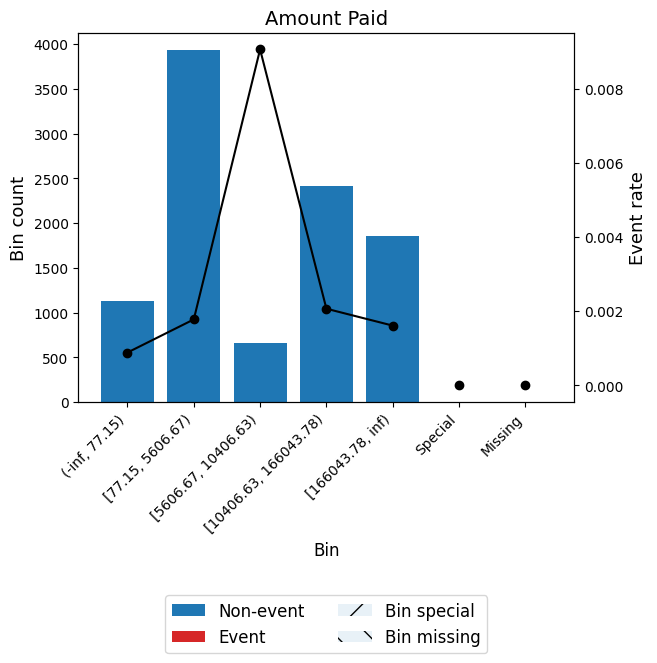

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 77.15)",1128,0.1128,1127,1,0.000887,0.910219,0.061434,0.007425
1,"[77.15, 5606.67)",3933,0.3933,3926,7,0.001780,0.212371,0.015988,0.001995
2,"[5606.67, 10406.63)",662,0.0662,656,6,0.009063,-1.422694,0.294473,0.033988
3,"[10406.63, 166043.78)",2417,0.2417,2412,5,0.002069,0.061678,0.000892,0.000111
4,"[166043.78, inf)",1860,0.1860,1857,3,0.001613,0.31101,0.015471,0.001926
5,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.388259,0.045446


In [ ]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True)
binned_var.binning_table.build()

Payment Format_ACH


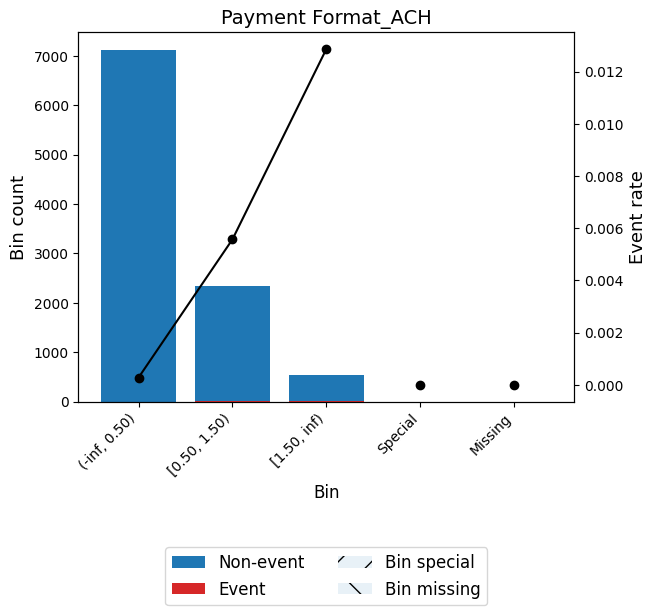

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",7124,0.7124,7122,2,0.000281,2.060701,1.283531,0.136979
1,"[0.50, 1.50)",2332,0.2332,2319,13,0.005575,-0.933154,0.334533,0.040363
2,"[1.50, inf)",544,0.0544,537,7,0.012868,-1.777008,0.469776,0.052041
3,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,2.087840,0.229383


In [ ]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True)
binned_var.binning_table.build()

Payment Format_Cheque


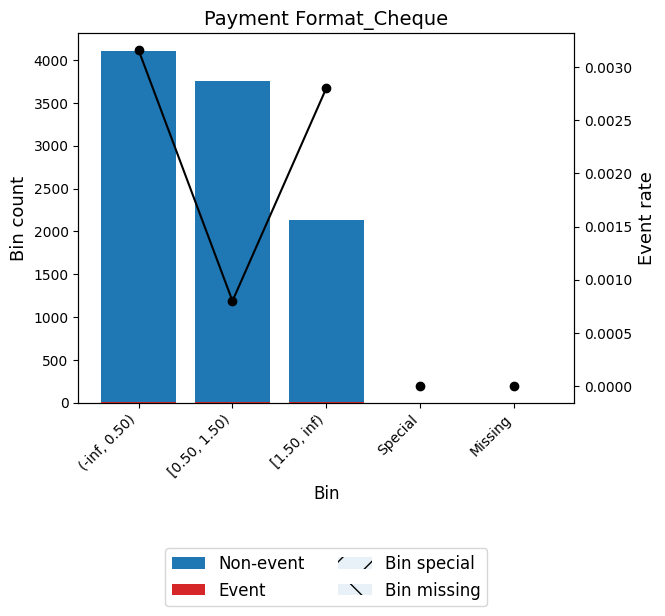

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",4110,0.4110,4097,13,0.003163,-0.364035,0.065638,0.008160
1,"[0.50, 1.50)",3751,0.3751,3748,3,0.000800,1.01327,0.242438,0.029071
2,"[1.50, inf)",2139,0.2139,2133,6,0.002805,-0.24357,0.014360,0.001791
3,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.322435,0.039022


In [ ]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True)
binned_var.binning_table.build()

Payment Format_Credit Card


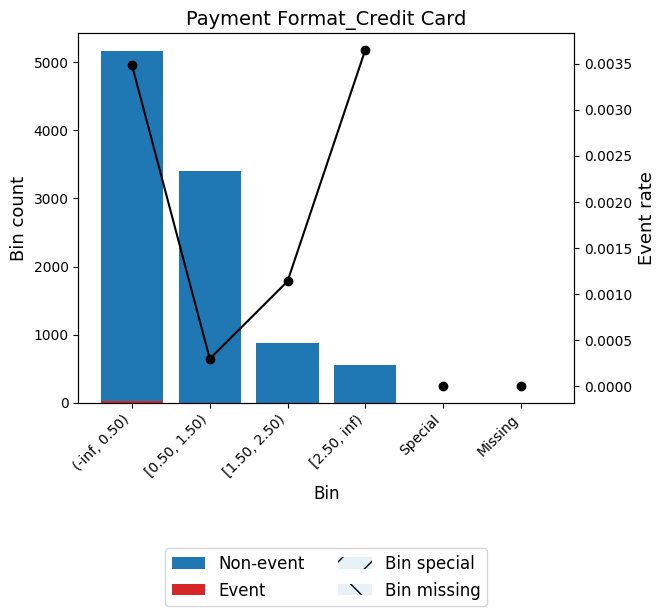

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",5170,0.5170,5152,18,0.003482,-0.460327,0.138948,0.017217
1,"[0.50, 1.50)",3402,0.3402,3401,1,0.000294,2.014729,0.595142,0.063914
2,"[1.50, 2.50)",880,0.0880,879,1,0.001136,0.661689,0.028214,0.003464
3,"[2.50, inf)",548,0.0548,546,2,0.003650,-0.507624,0.018370,0.002272
4,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.780674,0.086867


In [ ]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

Payment Currency_Euro


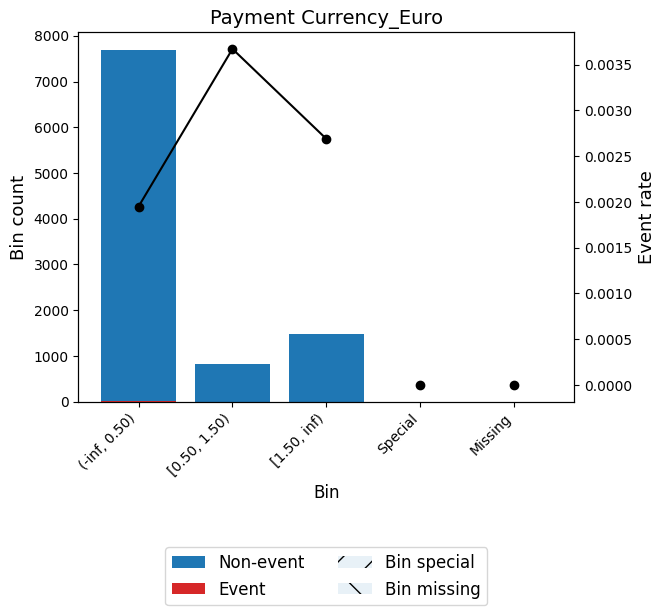

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",7695,0.7695,7680,15,0.001949,0.121229,0.010653,0.001331
1,"[0.50, 1.50)",817,0.0817,814,3,0.003672,-0.513747,0.028145,0.003480
2,"[1.50, inf)",1488,0.1488,1484,4,0.002688,-0.200893,0.006648,0.000830
3,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.045446,0.005640


In [ ]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

Payment Currency_US Dollar


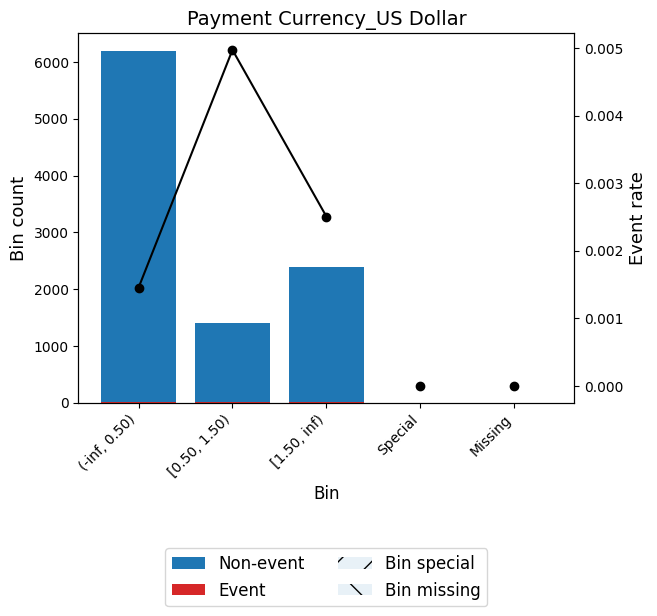

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",6198,0.6198,6189,9,0.001452,0.416209,0.087892,0.010908
1,"[0.50, 1.50)",1408,0.1408,1401,7,0.004972,-0.818064,0.145430,0.017688
2,"[1.50, inf)",2394,0.2394,2388,6,0.002506,-0.130643,0.004364,0.000545
3,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.237686,0.029141


In [ ]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

Receiving Currency_Euro


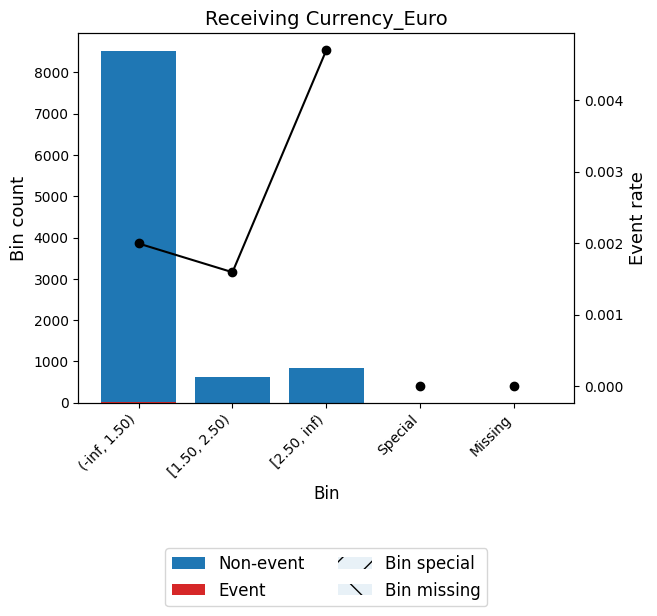

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",8522,0.8522,8505,17,0.001995,0.098101,0.007814,0.000976
1,"[1.50, 2.50)",628,0.0628,627,1,0.001592,0.323851,0.005630,0.000701
2,"[2.50, inf)",850,0.0850,846,4,0.004706,-0.76287,0.074023,0.009035
3,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.087466,0.010712


In [ ]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

Receiving Currency_US Dollar


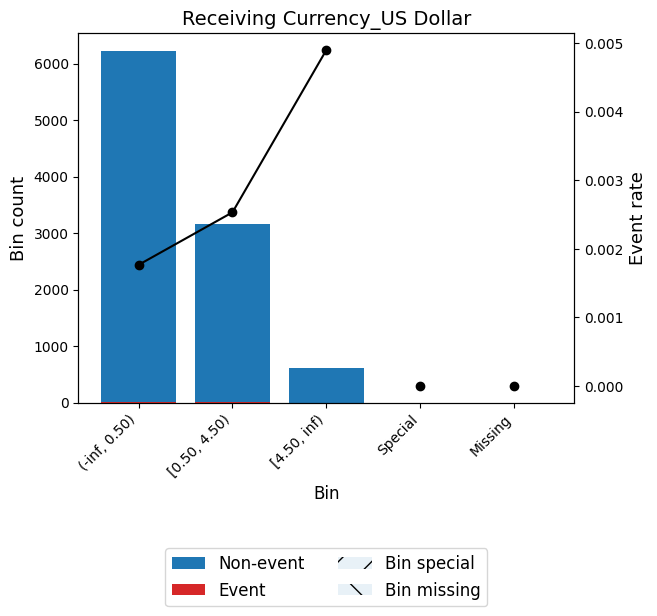

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",6229,0.6229,6218,11,0.001766,0.220213,0.027124,0.003384
1,"[0.50, 4.50)",3159,0.3159,3151,8,0.002532,-0.141062,0.006749,0.000843
2,"[4.50, inf)",612,0.0612,609,3,0.004902,-0.80389,0.060556,0.007372
3,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.094429,0.011599


In [ ]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

self_transfer


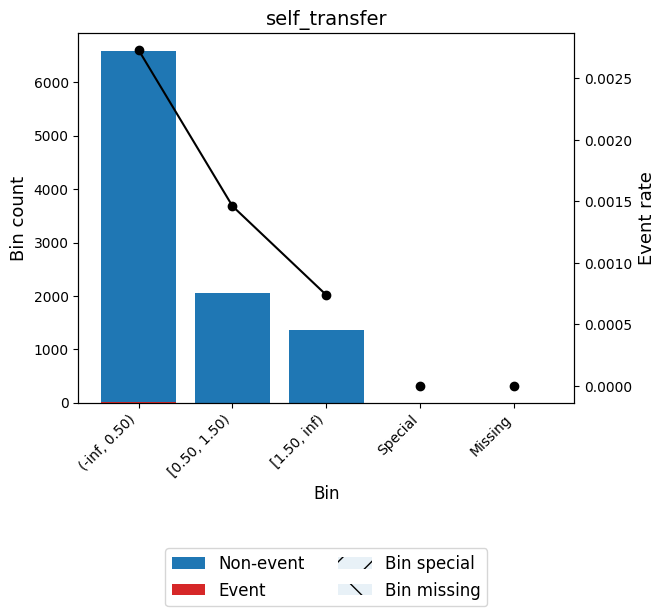

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",6592,0.6592,6574,18,0.002731,-0.216589,0.034510,0.004305
1,"[0.50, 1.50)",2053,0.2053,2050,3,0.001461,0.409887,0.028318,0.003515
2,"[1.50, inf)",1355,0.1355,1354,1,0.000738,1.093723,0.098702,0.011757
3,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.161530,0.019578


In [ ]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()

Account.1


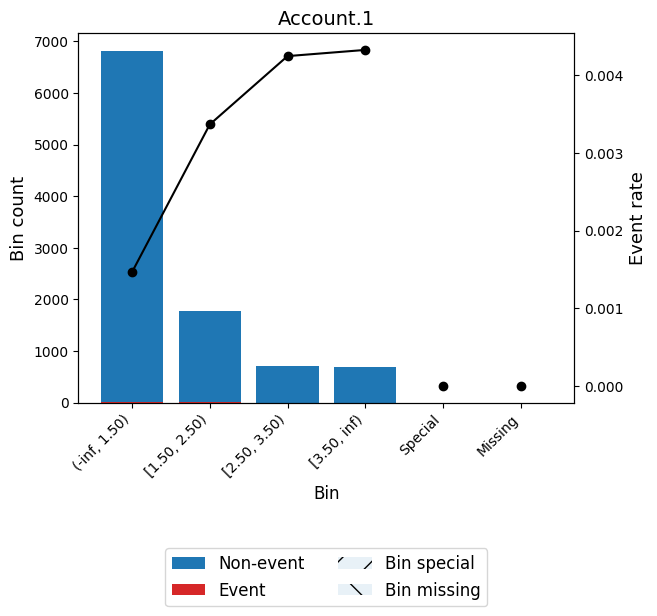

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",6820,0.6820,6810,10,0.001466,0.406467,0.092657,0.011503
1,"[1.50, 2.50)",1781,0.1781,1775,6,0.003369,-0.427299,0.040523,0.005027
2,"[2.50, 3.50)",706,0.0706,703,3,0.004249,-0.660351,0.043523,0.005344
3,"[3.50, inf)",693,0.0693,690,3,0.004329,-0.679016,0.045638,0.005598
4,Special,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.0000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,10000,1.0000,9978,22,0.002200,,0.222340,0.027471


In [ ]:
i = i+1
print(selected_features[i])

# Get the binned variable
binned_var = bp.get_binned_variable(selected_features[i])

# Build and plot the binning table
binning_table = binned_var.binning_table.build()
binned_var.binning_table.plot(metric="event_rate", show_bin_labels=True) #, add_special=False, add_missing=False
binned_var.binning_table.build()